In [31]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Reshape

In [32]:
df = pd.read_csv('../data/bitcoin2023_t.csv')
print(df)

   candle_date_time_kst  opening_price  high_price   low_price  trade_price   
0   2023-05-19T18:01:00     36216000.0  36217000.0  36216000.0   36216000.0  \
1   2023-05-19T18:01:00     36216000.0  36217000.0  36216000.0   36216000.0   
2   2023-05-19T18:01:00     36216000.0  36217000.0  36208000.0   36208000.0   
3   2023-05-19T18:01:00     36216000.0  36217000.0  36208000.0   36208000.0   
4   2023-05-19T18:01:00     36216000.0  36217000.0  36202000.0   36202000.0   
5   2023-05-19T18:01:00     36216000.0  36217000.0  36202000.0   36202000.0   
6   2023-05-19T18:01:00     36216000.0  36217000.0  36202000.0   36203000.0   
7   2023-05-19T18:01:00     36216000.0  36217000.0  36202000.0   36216000.0   
8   2023-05-19T18:02:00     36216000.0  36216000.0  36216000.0   36216000.0   
9   2023-05-19T18:02:00     36216000.0  36216000.0  36216000.0   36216000.0   
10  2023-05-19T18:02:00     36216000.0  36216000.0  36216000.0   36216000.0   
11  2023-05-19T18:02:00     36216000.0  36216000.0  

In [33]:
# 데이터 전처리
df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst']) #datetime 변환
df.set_index('candle_date_time_kst', inplace=True)

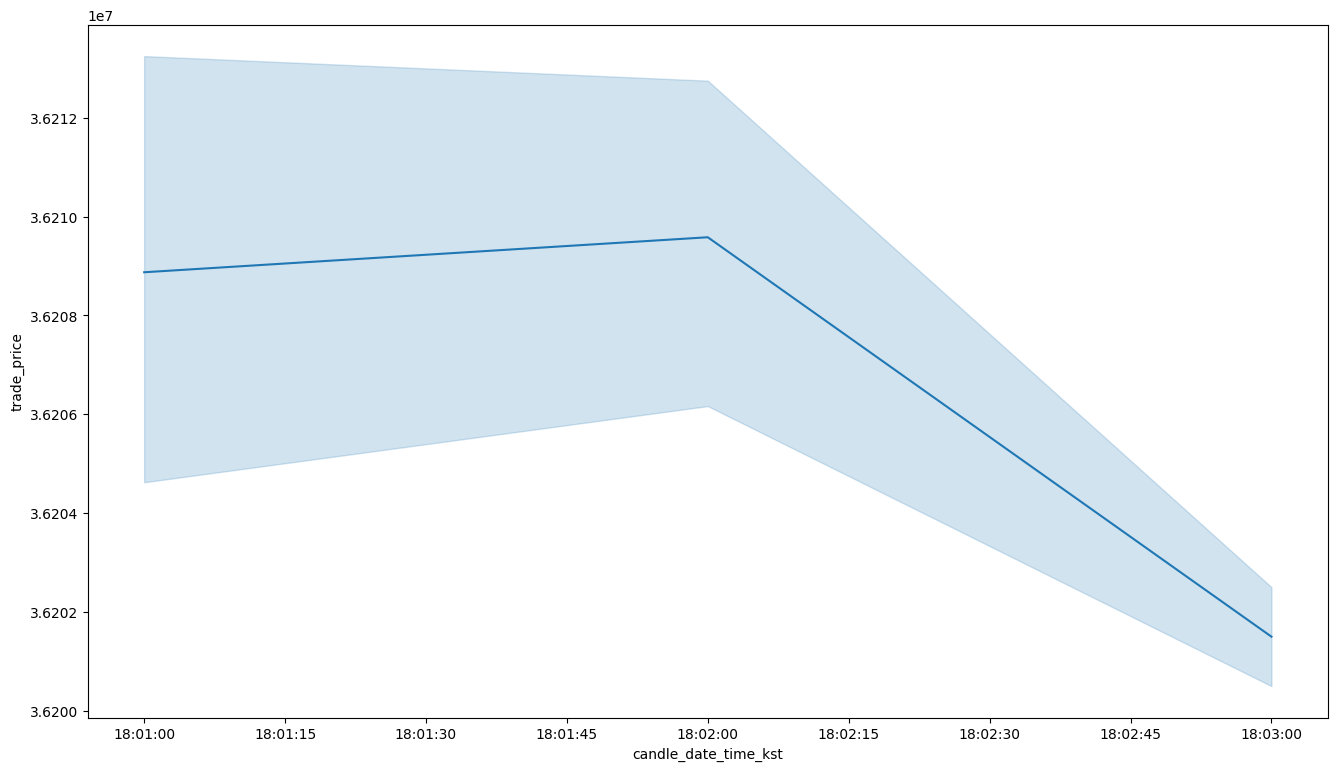

In [34]:
# 데이터 확인하기
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y="trade_price", data=df)
plt.xlabel("candle_date_time_kst")
plt.ylabel("trade_price")
plt.show()

In [35]:
# 결측치 처리
#df = df.asfreq('1T') #60 간격마다 보관 시계열이용하기위한
df = df.interpolate(method='linear')
df = df.fillna(method='ffill')

In [36]:
# 이상치 제거
df = df[(np.abs(df['trade_price']) < 3*df['trade_price'].std()) & 
            (np.abs(df['candle_acc_trade_price']) < 3*df['candle_acc_trade_price'].std())]

In [45]:
'''
# 데이터 정규화
scaler = MinMaxScaler()
scale_cols = ['candle_date_time_kst', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']
scaled = scaler.fit_transform(df[scale_cols])

# 데이터 셋 만들기
df = pd.DataFrame(scaled, columns=scale_cols)
print(df)
'''
# 인덱스 재설정
df = df.reset_index()

# 스케일링할 열 목록
scale_cols = ['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_price', 'candle_acc_trade_volume']

# 스케일링 작업 수행
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[scale_cols])

# 스케일링된 값을 가진 새로운 DataFrame 생성
df_scaled = pd.DataFrame(scaled, columns=scale_cols)
print(df_scaled)


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by MinMaxScaler.

In [19]:
# 데이터셋 분리 비율
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
'''
# 학습 데이터와 테스트 데이터로 분리
train_val_data, test_data = train_test_split(df, test_size=test_ratio, shuffle=False) #test_size 는 비율의미 shuffle=False 로 한이유는 시계열 특성을 고려?

# 학습 데이터와 검증 데이터로 분리
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio/(train_ratio+val_ratio), shuffle=False)
'''
# 학습 데이터와 테스트 데이터로 분리
test_data_size = int(len(df) * test_ratio)
train_val_data = df[:-test_data_size]
test_data = df[-test_data_size:]

# 학습 데이터와 검증 데이터로 분리
val_data_size = int(len(train_val_data) * val_ratio / (train_ratio + val_ratio))
train_data = train_val_data[:-val_data_size]
val_data = train_val_data[-val_data_size:]

# 데이터셋 생성 함수
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [20]:
# 학습 데이터셋 생성
n_timesteps = 24
X_train, y_train = create_dataset(train_data, train_data['trade_price'], n_timesteps)

# 검증 데이터셋 생성
X_val, y_val = create_dataset(val_data, val_data['trade_price'], n_timesteps)

# 테스트 데이터셋 생성
X_test, y_test = create_dataset(test_data, test_data['trade_price'], n_timesteps)


In [21]:
# CNN 모델과 LSTM 모델
n_features = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.025))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.025))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Reshape((-1, 64)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [22]:
# 모델 학습하기
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# 모델 평가하기
score = model.evaluate(X_test, y_test)
print("Test loss:", score)

Epoch 1/100
982/982 [==============================] - 6s 6ms/step - loss: 3.3098e-04 - val_loss: 0.0014
Epoch 2/100
982/982 [==============================] - 5s 5ms/step - loss: 9.6962e-05 - val_loss: 7.0214e-04
Epoch 3/100
982/982 [==============================] - 5s 5ms/step - loss: 6.0572e-05 - val_loss: 3.0433e-04
Epoch 4/100
982/982 [==============================] - 5s 6ms/step - loss: 5.8282e-05 - val_loss: 8.1739e-04
Epoch 5/100
982/982 [==============================] - 5s 6ms/step - loss: 6.0750e-05 - val_loss: 7.2943e-04
Epoch 6/100
982/982 [==============================] - 5s 6ms/step - loss: 5.7761e-05 - val_loss: 5.8096e-04
Epoch 7/100
982/982 [==============================] - 5s 5ms/step - loss: 4.6093e-05 - val_loss: 0.0010
Epoch 8/100
982/982 [==============================] - 5s 5ms/step - loss: 5.4253e-05 - val_loss: 0.0020
Epoch 9/100
982/982 [==============================] - 5s 5ms/step - loss: 4.7155e-05 - val_loss: 6.6598e-04
Epoch 10/100
982/982 [=========

In [23]:
# 모델 예측하기
y_pred = model.predict(X_test)

140/140 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))

# 사용 안해도된다.

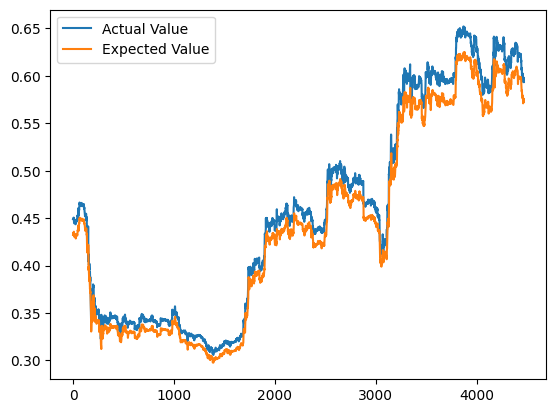

In [25]:
# 시각화 하기
plt.plot(y_test, label='Actual Value')
plt.plot(y_pred, label='Expected Value')
plt.legend()
plt.show()

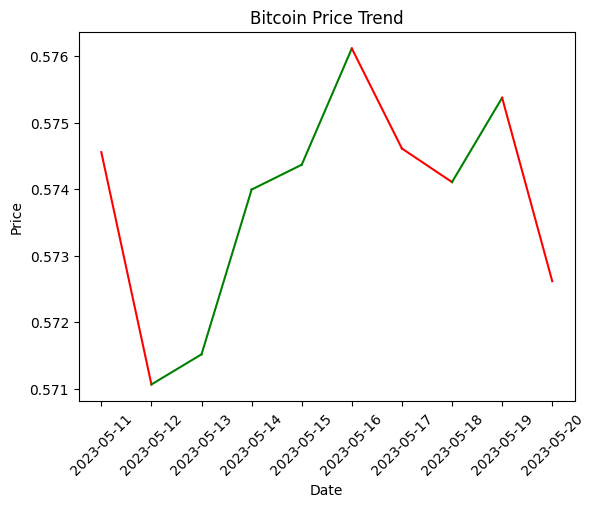

In [27]:
import matplotlib.pyplot as plt

# 데이터 준비
dates = [f"2023-05-{i}" for i in range(1, 31)]
dates_20 = dates[-20:]
y_pred_10 = y_pred[-10:]
y_pred_20 = y_pred_10[-20:]

# 상승/하락 여부에 따라 다른 색상의 선 그래프 그리기
fig, ax = plt.subplots()
for i in range(len(y_pred_20)-1):
    if y_pred_20[i+1] > y_pred_20[i]:
        ax.plot([dates_20[i], dates_20[i+1]], [y_pred_20[i], y_pred_20[i+1]], color='green')
    else:
        ax.plot([dates_20[i], dates_20[i+1]], [y_pred_20[i], y_pred_20[i+1]], color='red')

# 그래프 레이아웃 설정
ax.set_title('Bitcoin Price Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# 그래프 출력
plt.xticks(rotation=45)
plt.show()
